# **Курсовая работа по дисциплине "Автоматика и регулирование ЖРД"**

## Пробное решение

### Система уравнений

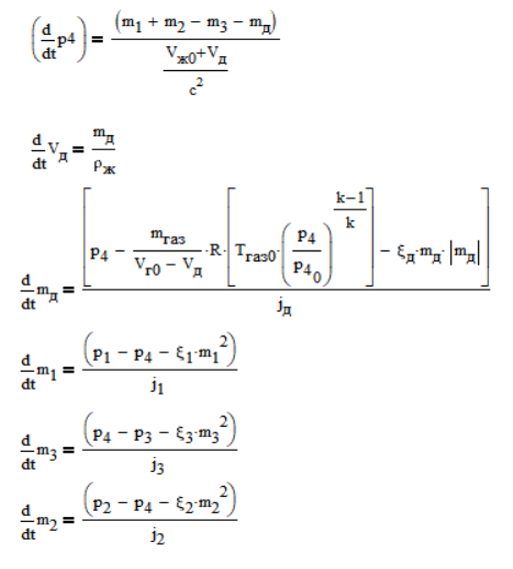

### Исходные данные

In [1]:
p1 = 400e3
p2 = 300e3
p3 = 100e3

k = 1.4
R = 297
p0_gas = 1.2506

c = 1200

p4_0 = 289442.719
Vд_0 = 0

mд_0 = 0
m1_0 = 10.515
m2_0 = 3.249
m3_0 = 13.764

Vж0 = 0.001
ρж = 820

mгаз = 0.005
Vг0 = 0.004
Tгаз0 = 293

j1 = 400
j2 = 400
j3 = 400
jд = 1000

ξ1 = 1000
ξ3 = 1000
ξд = 1000

### Решение СДУ

In [4]:
from scipy.integrate import odeint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def system(y, t):
    p4, Vд, mд, m1, m2, m3 = y
    
    d_p4 = (m1 + m2 - m3 - mд) / ((Vж0 + Vд) / c**2)
    d_Vд = mд / ρж
    d_mд = (p4 - (mгаз / (Vг0 - Vд)) * R * (Tгаз0 * ((p4 / p4_0)**((k-1)/k))) - ξд * mд * abs(mд)) / jд
    d_m1 = (p1 - p4 - ξ1 * m1**2) / j1
    d_m2 = (p2 - p4 - ξ2(t) * m2**2) / j2
    d_m3 = (p4 - p3 - ξ3 * m3**2) / j3
    
    return [d_p4, d_Vд, d_mд, d_m1, d_m2, d_m3]


def ξ2(t):
    if t <= 0.1/2:
        ξ2 = (1000 + 500*(np.sin(2*np.pi / 0.1*(t-0.1/4)) + 1))
    else:
        ξ2 = (1000 + 2*500)
    return ξ2


t_end = 6
num_points = 1_000_000
# t_end = 0.40977
# num_points = 40978

y0 = [p4_0, Vд_0, mд_0, m1_0, m2_0, m3_0]
t = np.linspace(0, t_end, num_points)

sol = odeint(system, y0, t)

print(pd.DataFrame(data=sol))

                    0             1         2          3         4          5
0       289442.719000  0.000000e+00  0.000000  10.515000  3.249000  13.764000
1       289438.036598  3.965804e-12  0.001084  10.515000  3.249000  13.764000
2       289423.991404  1.586303e-11  0.002168  10.515000  3.249000  13.764000
3       289400.589479  3.569115e-11  0.003252  10.515000  3.249001  13.763999
4       289367.839631  6.344934e-11  0.004335  10.515001  3.249002  13.763998
...               ...           ...       ...        ...       ...        ...
999995  284198.070739  2.476985e-03  0.000048  10.761134  2.810869  13.571956
999996  284198.067239  2.476985e-03  0.000048  10.761134  2.810869  13.571956
999997  284198.063731  2.476985e-03  0.000048  10.761134  2.810869  13.571956
999998  284198.060215  2.476985e-03  0.000048  10.761134  2.810869  13.571956
999999  284198.056692  2.476985e-03  0.000048  10.761134  2.810869  13.571956

[1000000 rows x 6 columns]


### Графики

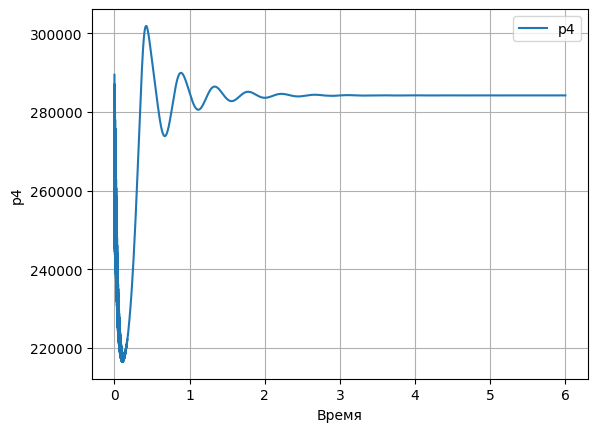

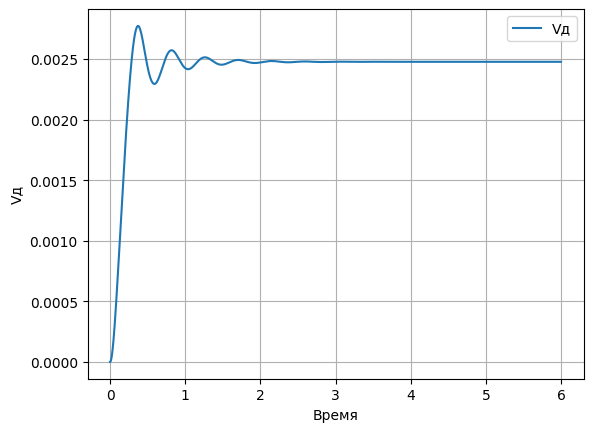

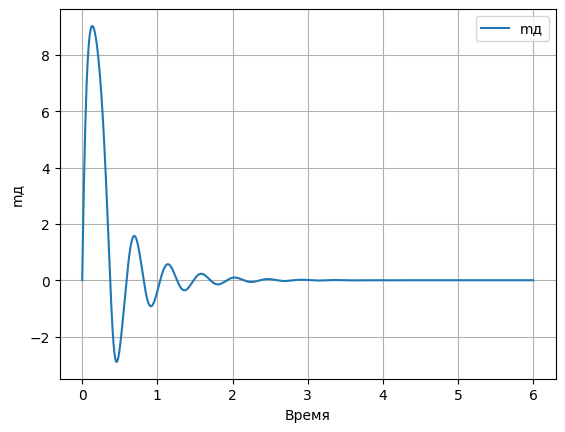

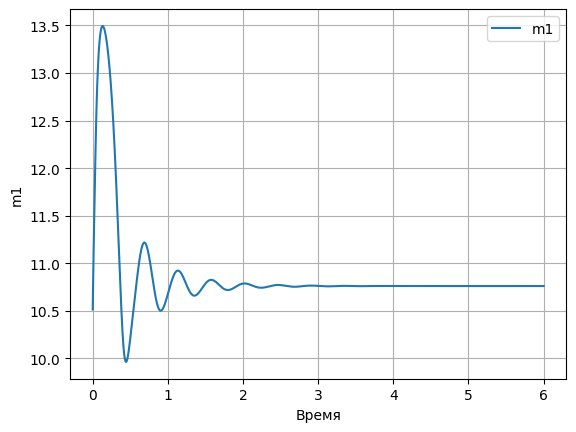

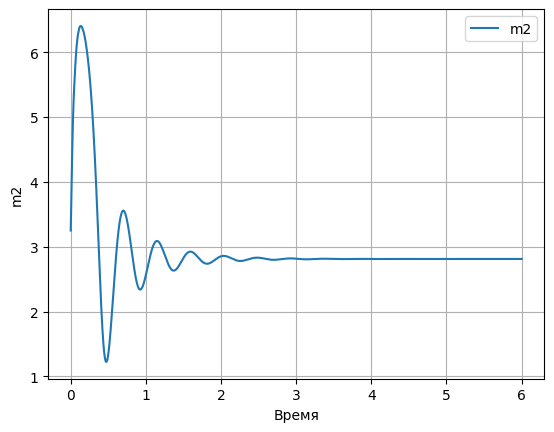

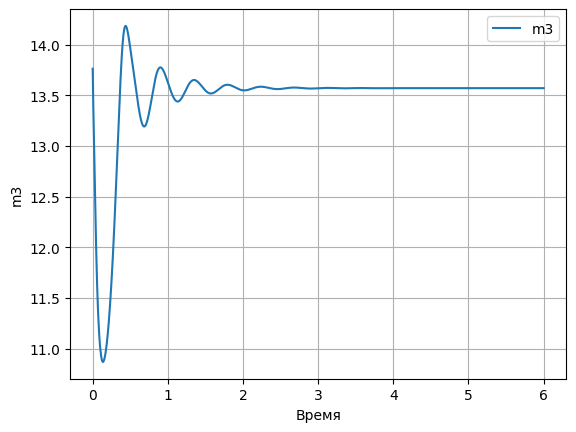

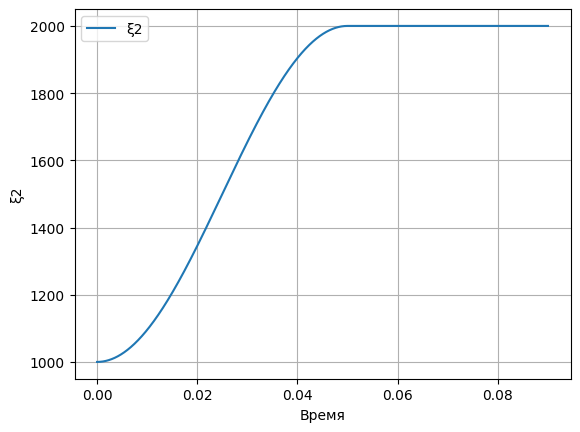

In [6]:
def plot(t, y, label):
    plt.plot(t, y, label=label)
    plt.grid(True)
    plt.xlabel("Время")
    plt.ylabel(label)
    plt.legend()
    plt.show()


plot(t, sol[:, 0], "p4")
plot(t, sol[:, 1], "Vд")
plot(t, sol[:, 2], "mд")
plot(t, sol[:, 3], "m1")
plot(t, sol[:, 4], "m2")
plot(t, sol[:, 5], "m3")
plot(t[:15000], [ξ2(t) for t in t][:15000], "ξ2")

### Построение характеристик

## Решение системы дифференциальных уравнений

### Система уравнений

### Исходные данные

### Решение

### Графики

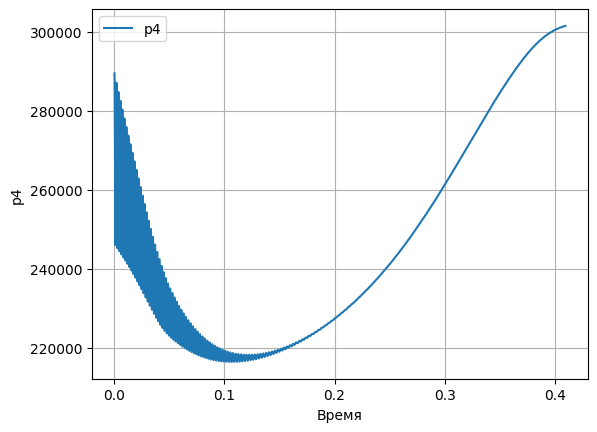

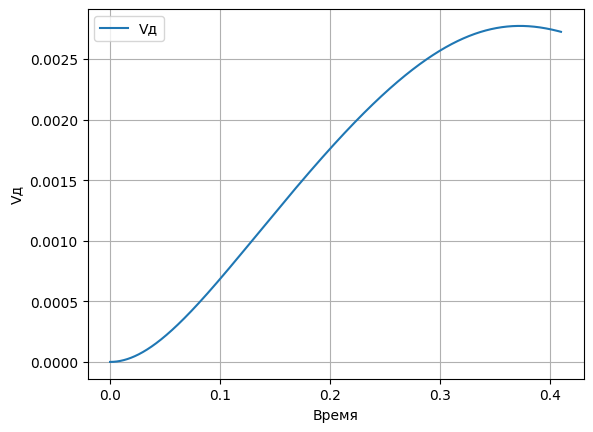

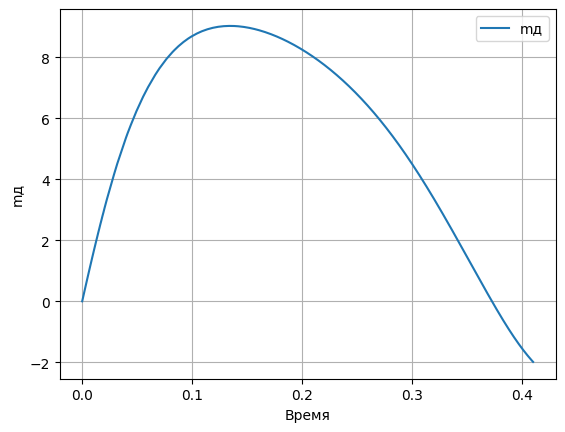

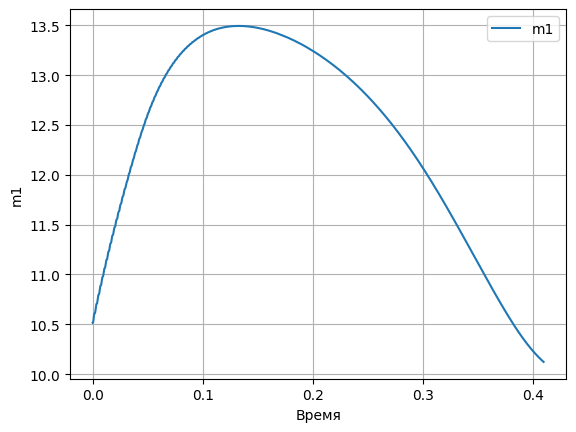

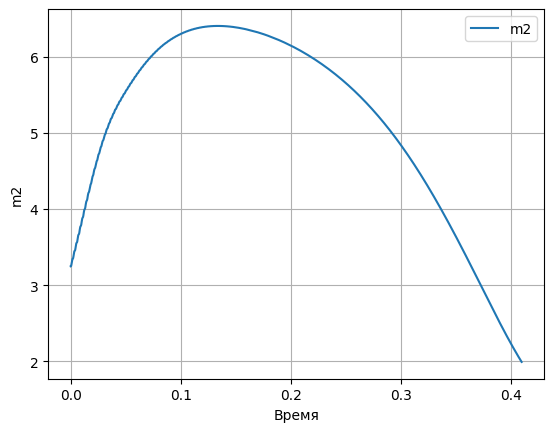

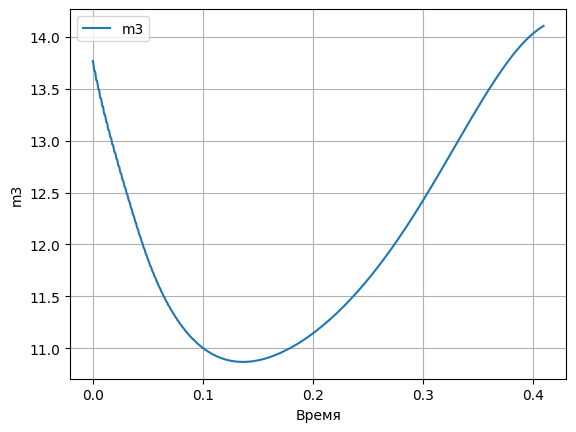

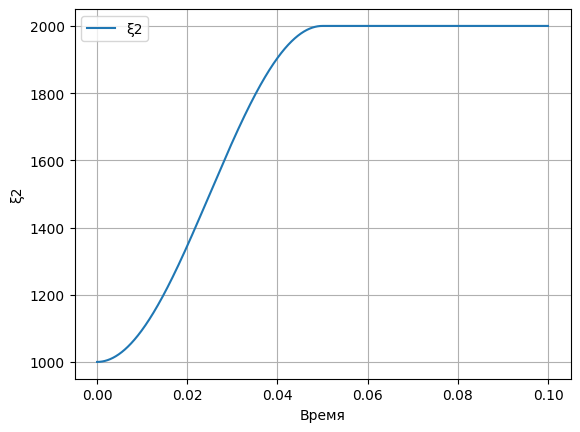

In [ ]:
def plot(t, y, label):
    plt.plot(t, y, label=label)
    plt.grid(True)
    plt.xlabel("Время")
    plt.ylabel(label)
    plt.legend()
    plt.show()


plot(t, sol[:, 0], "p4")
plot(t, sol[:, 1], "Vд")
plot(t, sol[:, 2], "mд")
plot(t, sol[:, 3], "m1")
plot(t, sol[:, 4], "m2")
plot(t, sol[:, 5], "m3")
plot(t[:10000], [ξ2(t) for t in t][:10000], "ξ2")

In [ ]:
from scipy.integrate import odeint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def system(y, t):
    p4, Vд, mд, m1, m2, m3 = y
    
    d_p4 = (m1 + m2 - m3 - mд) / ((Vж0 + Vд) / c**2)
    d_Vд = mд / ρж
    d_mд = (p4 - (mгаз / (Vг0 - Vд)) * R * (Tгаз0 * ((p4 / p4_0)**((k-1)/k))) - ξд * mд * abs(mд)) / jд
    d_m1 = (p1 - p4 - ξ1 * m1**2) / j1
    d_m2 = (p2 - p4 - ξ2(t) * m2**2) / j2
    d_m3 = (p4 - p3 - ξ3 * m3**2) / j3
    
    return [d_p4, d_Vд, d_mд, d_m1, d_m2, d_m3]


def ξ2(t):
    if t <= 0.1/2:
        ξ2 = (1000 + 500*(np.sin(2*np.pi / 0.1*(t-0.1/4)) + 1))
    else:
        ξ2 = (1000 + 2*500)
    return ξ2


t_end = 0.40977
num_points = 40978

y0 = [p4_0, Vд_0, mд_0, m1_0, m2_0, m3_0]
t = np.linspace(0, t_end, num_points)

sol = odeint(system, y0, t)

print(pd.DataFrame(data=sol))

                   0             1         2          3         4          5
0      289442.719000  0.000000e+00  0.000000  10.515000  3.249000  13.764000
1      289429.713183  1.101603e-11  0.001807  10.515000  3.249000  13.764000
2      289390.711107  4.406272e-11  0.003613  10.515001  3.249001  13.763999
3      289325.756772  9.913611e-11  0.005419  10.515002  3.249003  13.763997
4      289234.930191  1.762290e-10  0.007224  10.515006  3.249007  13.763993
...              ...           ...       ...        ...       ...        ...
40973  301458.943546  2.724549e-03 -1.986070  10.122868  1.994796  14.103543
40974  301459.679784  2.724525e-03 -1.986467  10.122769  1.994561  14.103607
40975  301460.415168  2.724501e-03 -1.986864  10.122671  1.994325  14.103671
40976  301461.149718  2.724477e-03 -1.987261  10.122573  1.994090  14.103734
40977  301461.883490  2.724452e-03 -1.987658  10.122475  1.993855  14.103798

[40978 rows x 6 columns]


In [ ]:
p1 = 400e3
p2 = 300e3
p3 = 100e3

k = 1.4
R = 297
p0_gas = 1.2506

c = 1200

p4_0 = 289442.719
Vд_0 = 0

mд_0 = 0
m1_0 = 10.515
m2_0 = 3.249
m3_0 = 13.764

Vж0 = 0.001
ρж = 820

mгаз = 0.005
Vг0 = 0.004
Tгаз0 = 293

j1 = 400
j2 = 400
j3 = 400
jд = 1000

ξ1 = 1000
ξ3 = 1000
ξд = 1000

![image.png](attachment:image.png)